In [34]:
import time
import numpy as np
import networkx as nx
from treesampling import algorithms
from treesampling.utils.graphs import random_uniform_graph, random_k_trees_graph, tuttes_tot_weight, normalize_graph_weights, reset_adj_matrix, tree_to_newick, graph_weight

In [25]:
records = []
# generate uniform graphs
n_nodes = 6
root = 0
graph = random_uniform_graph(n_nodes)
norm_graph = normalize_graph_weights(graph)
tot_weight = tuttes_tot_weight(norm_graph, root)
log_graph = reset_adj_matrix(graph, np.log(nx.to_numpy_array(graph)))

sample_size = 2000
sample = {}
acc_w = 0
num = 0
for i in range(sample_size):
    tree = algorithms.jens_rst(log_graph, root=root)
    tree_nwk = tree_to_newick(tree)
    if tree_nwk not in sample:
        weight = np.exp(graph_weight(tree, log_probs=True))
        sample[tree_nwk] = weight
        acc_w += weight
        num += 1
        records.append([i, acc_w / tot_weight, acc_w, num, 'unif'])

/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_29399/2859255398.py:8: RuntimeWarning: divide by zero encountered in log
  log_graph = reset_adj_matrix(graph, np.log(nx.to_numpy_array(graph)))


In [43]:
records = []
time_rec = []
rand_k_param = 100
for n_nodes in [6, 7, 8, 9, 10]:
    graph = random_k_trees_graph(n_nodes, rand_k_param)
    norm_graph = normalize_graph_weights(graph)
    tot_weight = tuttes_tot_weight(norm_graph, root)
    log_graph = reset_adj_matrix(graph, np.log(nx.to_numpy_array(graph)))

    sample_size = 20000
    sample = {}
    acc_w = 0
    num = 0
    start_time = time.time()
    for i in range(sample_size):
        tree = algorithms.jens_rst(log_graph, root=root)
        tree_nwk = tree_to_newick(tree)
        if tree_nwk not in sample:
            weight = np.exp(graph_weight(tree, log_probs=True))
            sample[tree_nwk] = weight
            acc_w += weight
            num += 1
            records.append([i, acc_w / tot_weight, acc_w, num, n_nodes, str(rand_k_param)+'-tree'])
    end_time = time.time() - start_time
    time_rec.append([n_nodes, end_time])


((((5)1,3)4)2)0
(((4,5)1)2,(3)6)0
(((((5)3,(6)7)4)2)1)0
(((2)8)1,((5,(4)7)3)6)0
(((7,((4,(8)5,6)1)9)3)2)0


In [44]:
import pandas as pd
rec_df = pd.DataFrame(records, columns=['n_draws', 'acc_prob', 'draw_prob', 'acc_discovery', 'n_nodes', 'graph_type'])
time_df = pd.DataFrame(time_rec, columns=['n_nodes', 'time'])
rec_df.to_csv(f'./convergence_in_prob_{rand_k_param}-tree.csv')
time_df.to_csv('./time_by_nodes.csv')

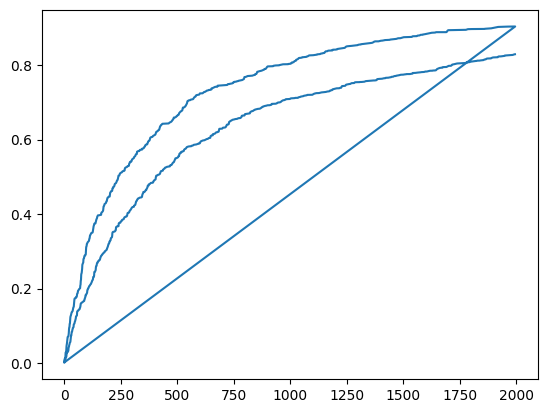

In [32]:
import matplotlib.pyplot as plt
plt.plot(rec_df['n_draws'], rec_df['acc_prob'], label=rec_df['graph_type'])


In [41]:


















time_df

























,n_nodes,time
0,6,10.300103
1,7,17.493573
2,8,22.933529
3,9,41.656326
4,10,46.097801


In [42]:
rec_df[rec_df['n_nodes'] == 10]

,n_draws,acc_prob,draw_prob,acc_discovery,n_nodes,graph_type
49584,0,2.306220e-07,1.688928e-08,1,10,3-tree
49585,1,2.750946e-07,2.014617e-08,2,10,3-tree
49586,2,2.851992e-07,2.088617e-08,3,10,3-tree
49587,3,2.913064e-07,2.133342e-08,4,10,3-tree
49588,4,2.935766e-07,2.149967e-08,5,10,3-tree
...,...,...,...,...,...,...
69568,19995,6.327775e-04,4.634058e-05,19985,10,3-tree
69569,19996,6.327932e-04,4.634173e-05,19986,10,3-tree
69570,19997,6.328454e-04,4.634555e-05,19987,10,3-tree
69571,19998,6.328560e-04,4.634633e-05,19988,10,3-tree
